<a href="https://colab.research.google.com/github/CadeHarger/portfolio/blob/main/Personal_Projects/Chess_AI_Round_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python-chess==0.31.3
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals


In [ ]:
#@title Import Relevant Modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import chess
import chess.svg
import chess.pgn
import random
import time

In [ ]:
#@title Feature Creation

numFeats = 20
movesPerGame = 2

squares_index = {
  'a': 0,
  'b': 1,
  'c': 2,
  'd': 3,
  'e': 4,
  'f': 5,
  'g': 6,
  'h': 7
}

positionalEncoding = np.zeros((2, 8, 8), dtype=np.int8)
for x in range(8):
  positionalEncoding[0][x] += x
  for y in range(8):
    positionalEncoding[1][x][y] += y

'''
# ex: h3 -> 17
def square_to_index(square):
  letter = chess.square_name(square)
  return 8 - int(letter[1]), squares_index[letter[0]]
'''

def comprehendBoard(board):
  board3d = np.zeros((numFeats - 2, 8, 8), dtype=np.int8)

  # get the location of each piece
  for piece in chess.PIECE_TYPES:
    for square in board.pieces(piece, chess.WHITE):
      idx = np.unravel_index(square, (8, 8))
      board3d[piece - 1][7 - idx[0]][idx[1]] = 1
    for square in board.pieces(piece, chess.BLACK):
      idx = np.unravel_index(square, (8, 8))
      board3d[piece + 5][7 - idx[0]][idx[1]] = 1
  # get the number of attackers on each square for each side

  for square in chess.SQUARES:
    idx = np.unravel_index(square, (8, 8))
    board3d[12][idx[0]][idx[1]] = len(board.attackers(chess.WHITE, square))
  for square in chess.SQUARES:
    idx = np.unravel_index(square, (8, 8))
    board3d[13][idx[0]][idx[1]] = len(board.attackers(chess.BLACK, square))
  board3d[14] = np.zeros((8, 8), dtype = np.int8) + board.turn
  board3d[15] = np.zeros((8, 8), dtype = np.int8) + int(len(board.move_stack) / 8)
  board3d[16] = np.zeros((8, 8), dtype = np.int8) + board.has_kingside_castling_rights(chess.WHITE) + (2 * board.has_kingside_castling_rights(chess.WHITE)) + (4 * board.has_kingside_castling_rights(chess.BLACK)) + (8 * board.has_kingside_castling_rights(chess.BLACK))
  board3d[17] = np.zeros((8, 8), dtype = np.int8) + board.is_repetition(1) + board.is_repetition(2)

  return np.reshape(np.append(board3d, positionalEncoding, axis=0), newshape=(64, numFeats))
board = chess.Board()
print(comprehendBoard(board).shape)

In [ ]:
#@title Load the Dataset
trainData = pd.read_csv("ChessGames.csv")
trainData = trainData.to_numpy()
np.random.shuffle(trainData)
print(len(trainData))

# Create features/labels from dataset
betaFeatureSet = np.zeros((len(trainData) * movesPerGame, 64, numFeats), dtype=np.int8)
betaLabelSet = np.zeros((len(trainData) * movesPerGame, 2), dtype=np.float16)
for x in range(len(trainData)):
  moves = trainData[x][3].split()
  for y in range(movesPerGame):
    board = chess.Board()
    randomMove = random.randrange(5, len(moves))
    for i in range(randomMove):
      board.push(board.parse_san(moves[i]))
    betaLabelSet[(x * movesPerGame) + y][0] = trainData[x][1] * -0.5 + 0.5 # One-hot encode -1, 0, 1 values
    betaLabelSet[(x * movesPerGame) + y][1] = trainData[x][1] * 0.5 + 0.5
    betaFeatureSet[(x * movesPerGame) + y] = comprehendBoard(board)

del trainData

print(len(betaFeatureSet))
print(len(betaLabelSet))

print(np.histogram(betaLabelSet, bins=2))

16153
32306
32306
(array([30784, 33828]), array([0. , 0.5, 1. ], dtype=float16))


In [ ]:
#@title Mount Google Drive
import os
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
#@title Load the Dataset from Drive

minLength = 6

tic = time.perf_counter()
games = []
path = "/gdrive/MyDrive/AI Stuff/Chess/"
for filename in os.listdir(path):
  print(filename)
  if filename.endswith("txt"):
    with open(path + filename, 'r', encoding='latin-1') as file:
      parsing = False
      san = ""
      for i, line in enumerate(file):
        if parsing:
          if line == '\n':
            parsing = False
            moves = san.split()
            if len(moves) > minLength:
              games.append(moves)
            san = ""
          else:
            san += line
        elif line[0] == '1':
          parsing = True
          san += line
      print(i)
print(len(games))
toc = time.perf_counter()
print(f'Time: {toc - tic} seconds')

featureSetX = np.zeros((len(games) * movesPerGame, 64, numFeats), dtype=np.int8)
labelSetX = np.zeros((len(games) * movesPerGame, 2), dtype=np.float16) # Black Score, White Score
for gameNo, game in enumerate(games):
  if gameNo % 30000 == 0:
    print(gameNo)
  for x in range(movesPerGame):
    board = chess.Board()
    randomMove = random.randrange(minLength, len(game) - 1)
    for i in range(randomMove):
      if '.' in game[i]:
        try:
          board.push(board.parse_san(game[i].split('.')[1]))
        except:
          print(game[i].split('.'), game)
          #board.push(board.parse_san('Rg1'))
      else:
        board.push(board.parse_san(game[i]))
    index = gameNo * movesPerGame + x
    outcome = game[-1]
    featureSetX[index] = comprehendBoard(board)
    if outcome[0] == '1':
      if outcome[1] == '/':
        labelSetX[index][0] = 0.5
        labelSetX[index][1] = 0.5
      else:
        labelSetX[index][0] = 0
        labelSetX[index][1] = 1
    else:
      labelSetX[index][0] = 1
      labelSetX[index][1] = 0

del games

# Diagnostics
print(len(featureSetX))
print(len(labelSetX))

print(np.histogram(labelSetX, bins=2))
print(f'Time: {time.perf_counter() - toc} seconds')
print(np.shape(featureSetX))


4.txt
503282
7.txt
155187
8.txt
587253
10.txt
208108
11.txt
385459
13.txt
463953
2.txt
640675
3.txt
244347
5.txt
207586
9.txt
397980
0.txt
574646
6.txt
310895
259237
Time: 11.605844502000025 seconds
0
30000
60000
90000
120000
150000
180000
210000
240000
518474
518474
(array([357390, 679558]), array([0. , 0.5, 1. ], dtype=float16))
Time: 1737.3200367279999 seconds
(518474, 64, 20)


In [ ]:
#@title Merging Datasets

testSize = 30000

featureSet = np.append(featureSetX, betaFeatureSet, axis=0)
labelSet = np.append(labelSetX, betaLabelSet, axis=0)
print(np.shape(featureSet))
print(np.shape(labelSet))

# Shuffle the features and labels together
shuffler = np.random.permutation(len(featureSet))
featureSet = featureSet[shuffler]
labelSet = labelSet[shuffler]

(550780, 64, 20)
(550780, 2)


In [ ]:
#@title Define the plotting function
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

Loaded the plot_curve function.


In [ ]:
#@title Define Model Functions
def scaled_dot_product_attention(q, k, v):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
#@title Define the Model
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, dims, heads):
    super(MultiHeadAttention, self).__init__()
    self.heads = heads
    self.dims = dims
    assert dims % heads == 0

    self.depth = dims // heads

    self.wq = tf.keras.layers.Dense(dims)
    self.wk = tf.keras.layers.Dense(dims)
    self.wv = tf.keras.layers.Dense(dims)
    self.dense = tf.keras.layers.Dense(dims)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q):
    batchSize = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, 64, d_model)
    k = self.wk(k)  # (batch_size, 64, d_model)
    v = self.wv(v)  # (batch_size, 64, d_model)

    q = self.split_heads(q, batchSize)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batchSize)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batchSize)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batchSize, -1, self.dims))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

class TransformLayer(tf.keras.layers.Layer):
  def __init__(self, dims, heads, ffDims, dropoutRate):
    super(TransformLayer, self).__init__()
    self.attention = MultiHeadAttention(dims, heads)
    self.feedForward = tf.keras.Sequential([tf.keras.layers.Dense(ffDims, activation='relu'), tf.keras.layers.Dense(dims)])

    self.layerNorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layerNorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(dropoutRate)
    self.dropout2 = tf.keras.layers.Dropout(dropoutRate)

  def call(self, x):
    attentionOutput, _ = self.attention(x, x, x)
    attentionOutput = self.dropout1(attentionOutput, training=True)
    attentionOutput = self.layerNorm1(x + attentionOutput)

    feedOutput = self.feedForward(attentionOutput)
    feedOutput = self.dropout2(feedOutput, training=True)
    feedOutput = self.layerNorm2(attentionOutput + feedOutput)

    return feedOutput


In [ ]:
#@title Create the Model
dense = 768
dropout = 0.07
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(64, numFeats)),
  TransformLayer(numFeats, 5, dense, dropout),
  TransformLayer(numFeats, 5, dense, dropout),
  TransformLayer(numFeats, 5, dense, dropout),
  TransformLayer(numFeats, 5, dense, dropout),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2, activation='softmax')
])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transform_layer_3 (Transform (None, 64, 20)            33268     
_________________________________________________________________
transform_layer_4 (Transform (None, 64, 20)            33268     
_________________________________________________________________
transform_layer_5 (Transform (None, 64, 20)            33268     
_________________________________________________________________
transform_layer_6 (Transform (None, 64, 20)            33268     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 2)                 2562      
Total params: 135,634
Trainable params: 135,634
Non-trainable params: 0
________________________________________________

In [ ]:
#@title Model Training
def trainModel(model, features, label, epochs,
                batchSize=None, validationSplit=0.1):

  history = model.fit(x=features, y=label, batch_size=batchSize,
                      epochs=epochs, shuffle=True, validation_split=validationSplit)

  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist

In [ ]:
#@title The AI

lr = 0.002
epochs = 16
batchSize = 256
validationSplit = 0.1

metrics = ['loss', 'val_loss']
model.compile(optimizer='adam', loss='categorical_crossentropy')

epochs, hist = trainModel(model, featureSet, labelSet, epochs, batchSize, validationSplit)
plot_curve(epochs, hist, metrics)

print("Evaluate Model on Test Set:")
model.evaluate(x = testFeatureSet, y = testLabelSet, batch_size=batchSize)

Epoch 1/16
1937/1937 [==============================] - 199s 100ms/step - loss: 0.6860 - val_loss: 0.6716
Epoch 2/16
1937/1937 [==============================] - 191s 99ms/step - loss: 0.6638 - val_loss: 0.6601
Epoch 3/16
1937/1937 [==============================] - 192s 99ms/step - loss: 0.6568 - val_loss: 0.6553
Epoch 4/16
1937/1937 [==============================] - 192s 99ms/step - loss: 0.6532 - val_loss: 0.6523
Epoch 5/16
 131/1937 [=>............................] - ETA: 2:51 - loss: 0.6521

In [ ]:
#@title Generating AI Move

def getAIMove(board, movesAhead, boardCache):
  tic = time.perf_counter()
  moveTree = Node(board)
  totalPly = movesAhead * 2
  generateMoveTree(moveTree, totalPly)
  print("Tree Generated")
  eval = minimax(moveTree, totalPly, -4, 4, 1, boardCache)
  return moveTree.children[[move.score for move in moveTree.children].index(eval)].data.copy()

class Node():
  def __init__(self, data):
    self.data = data
    self.children = 0
    self.score = 0.0
  def setChildren(self,obj):
    self.children = obj

class PositionCache():
  def __init__(self):
    self.cache = {}

# Generates a tree of possible moves with n ply
def generateMoveTree(move, n):
  children = [Node(move.data.copy()) for available in move.data.legal_moves]
  for i, available in enumerate(move.data.legal_moves):
    children[i].data.push(available)
  move.setChildren(children)
  if n - 1 != 0:
    for node in move.children:
      generateMoveTree(node, n - 1)

# Alpha = worst possible score for white assuming white plays logically (WRONG)
# Beta = the exact oppposite
# Best Black = -1, Best White = 1
# Currently only works if depth is inititally even because of lack of
# turn data being passed to the model
# Yes, alphabeta works
def minimax(moveTree, depth, alpha, beta, isWhite, boardCache):
  if moveTree.data.is_checkmate():
    moveTree.score = (not isWhite) * 3 - 1
    return moveTree.score # the turn is whoever got mated
  if depth == 0:
    fen = moveTree.data.fen()[:-5]
    if fen in boardCache.cache.keys():
      moveTree.score = boardCache.cache[fen]
      return moveTree.score
    else:
      features = np.zeros((1, 64, numFeats), dtype=np.int8)
      features[0] = comprehendBoard(moveTree.data) # Must be better solutions than calling predict
      prediction = model.predict(features)
      moveTree.score = prediction[0][1] - prediction[0][0] # White - Black
      boardCache.cache[fen] = moveTree.score
      return moveTree.score
  if isWhite:
    maximum = -3
    for node in moveTree.children:
      eval = minimax(node, depth - 1, alpha, beta, 0, boardCache)
      maximum = max(maximum, eval)
      alpha = max(alpha, eval)
      if beta <= alpha:
        break
    moveTree.score = maximum
    return maximum
  else:
    minimum = 3
    for node in moveTree.children:
      eval = minimax(node, depth - 1, alpha, beta, 1, boardCache)
      minimum = min(minimum, eval)
      beta = min(beta, eval)
      if beta <= alpha:
        break
    moveTree.score = minimum # Necessary?
    return minimum


r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R

r n b q k b . r
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . . . P . . .
. . . . . N . .
P P P P . P P P
R N B Q K B . R
Tree Generated
Time: 13.388346119000744 seconds

r n b q k b . r
p p p . p p p p
. . . . . . . n
. B . p . . . .
. . . . P . . .
. . . . . N . .
P P P P . P P P
R N B Q K . . R
Tree Generated
Time: 6.332782982000026 seconds

r n . q k b . r
p p p B p p p p
. . . . . . . n
. . . p . . . .
. . . . P . . .
. . . . . N . .
P P P P . P P P
R N B Q K . . R
Tree Generated
Time: 17.40902768000069 seconds

r . . q k b . r
p p p n p p p p
. . . . . . . n
. . . p . . . .
. . . . P . . .
. . . . . N . .
P P P P . P P P
R N B Q K R . .
Tree Generated
Time: 16.995482514000287 seconds

r . . q k b . r
. p p n p p p p
. . . . . . . n
p . . p . . . .
. . . P P . . .
. . . . . N . .
P P P . . P P P
R N B Q K R . .
Tree Generated
Time: 11.396861735000

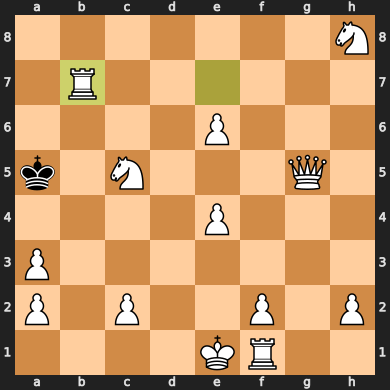

In [ ]:
#@title Testing Play

def playerVsAI():
  board = chess.Board()
  boardCache = PositionCache()
  moveCount = 0
  while True:
    if moveCount == 0:
      board.push(board.parse_san('e4'))
    elif moveCount == 1:
      board.push(board.parse_san('Nf3'))
    else:
      tic = time.perf_counter()
      newBoard = getAIMove(board, boardCache)
      board.push(newBoard.move_stack[-1])
      print(f'Time: {time.perf_counter() - tic} seconds')
    print(f'\n{board}')
    if board.is_game_over():
        break
    while True:
      move = input("Enter a move: ")
      try:
        board.push_san(move)
        break
      except:
        print('Invalid move')
    if board.is_game_over():
        break
    moveCount += 1

def randomVsAI(board):
  boardCache = PositionCache()
  moveCount = 0
  while True:
    if moveCount == 0:
      board.push(board.parse_san('e4'))
    elif moveCount == 1:
      board.push(board.parse_san('Nf3'))
    else:
      tic = time.perf_counter()
      newBoard = getAIMove(board, 1, boardCache)
      board.push(newBoard.move_stack[-1])
      print(f'Time: {time.perf_counter() - tic} seconds')
    print(f'\n{board}')
    if board.is_game_over():
        break
    moves = [move for move in board.legal_moves]
    board.push(moves[random.randrange(0, len(moves))])
    if board.is_game_over():
        break
    moveCount += 1

def AIVsAI(board, movesAhead, variance, boardCache):
  treeGenTime = 0
  minimaxTime = 0
  board.push(board.parse_san('e4'))
  board.push(board.parse_san('e5'))
  board.push(board.parse_san('Nf3'))
  board.push(board.parse_san('Nc6'))
  totalPly = movesAhead * 2
  while 1:
    tic = time.perf_counter()
    moveTree = Node(board)
    generateMoveTree(moveTree, totalPly)
    treeGenTime += time.perf_counter() - tic
    print("Tree Generated")
    toc = time.perf_counter()
    eval = minimax(moveTree, totalPly, -4, 4, board.turn, boardCache)
    print(eval)
    minimaxTime += time.perf_counter() - toc

    if board.turn:
      scores = [move.score for move in moveTree.children]
    else:
      scores = [move.score * -1 + 1 for move in moveTree.children]
    index = np.argmax(np.add(scores, (np.random.rand(len(scores)) - 0.5) * np.std(scores) * 2 * variance))
    board.push(moveTree.children[index].data.move_stack[-1])
    print(f'Time: {time.perf_counter() - tic} seconds')
    print(f'Cached Positions: {len(boardCache.cache.keys())}')
    print(f'\n{board}')
    if board.is_game_over():
      for move in moveTree.children:
        print(move.score)
        if move.score == 0.0:
          print(move.data)
      break
  print("Tree Generation Time: ", end="")
  print(treeGenTime)
  print("Average Tree Generation Time: ", end="")
  print(treeGenTime / len(board.move_stack))
  print("Total Minimax Time: ", end="")
  print(minimaxTime)
  print("Average Minimax Time: ", end="")
  print(minimaxTime / len(board.move_stack))

movesAhead =  1#@param{type:"integer"}
variance = 0 #@param{type:"integer"} Number of standard deviations to modify the scores for each move by
board = chess.Board()
trueCache = PositionCache()
#AIVsAI(board, movesAhead, variance, trueCache)
randomVsAI(board)
board


In [ ]:
prev = 0
newBoard = chess.Board()

In [ ]:
newBoard.push(board.move_stack[prev])
prev += 1
newBoard

IndexError: ignored

High score loss: 0.6373

20 epochs 0.001 lr 256 bs

3 layer transformers, 0.05 dropout 768 dims 1-5-5 heads



TO ADD? :

